## LIBRERIAS

In [ ]:
import shutil
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import Xception
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input

## CARGAMOS LA BASE DE DATOS

In [ ]:
# Crear la carpeta .kaggle si no existe
os.makedirs("/root/.kaggle", exist_ok=True)
# Mover el archivo kaggle.json a la carpeta
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")
# Dar permisos adecuados
os.chmod("/root/.kaggle/kaggle.json", 600)

In [ ]:
!kaggle datasets download -d deathperminut/material-spinners-data

Dataset URL: https://www.kaggle.com/datasets/deathperminut/material-spinners-data
License(s): CC0-1.0
 99% 125M/126M [00:06<00:00, 24.3MB/s]
100% 126M/126M [00:06<00:00, 19.2MB/s]


In [ ]:
# Nombre del archivo descargado (ajústalo según sea necesario)
dataset_zip = "/content/material-spinners-data.zip"
# Extraer los archivos
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("dataset")
# Ver archivos extraídos
os.listdir("dataset")

['__notebook__.ipynb', 'data.npy.npz']

In [ ]:
#load data
file_ = '/content/dataset/data.npy.npz'
data = np.load(file_)
T,Jex2 =data['T'],data['Jex2']

In [ ]:
# Cargar nuevamente

loaded = np.load("/content/drive/MyDrive/imagenes_comprimidas.npz")
MS = loaded["data"].astype('float16')
Y_ = Jex2.reshape(-1, 1)

In [ ]:
del loaded
# 1. Dividir los datos en entrenamiento, validación y prueba
X_train, X_val, y_train, y_val = train_test_split(MS, Jex2.reshape(-1, 1), test_size=0.2, random_state=42)
del MS, Jex2
# 2. Aplicar MinMaxScaler a y_train, y_val, y_test
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_val_scaled = scaler.transform(y_val)

# 3. Crear `tf.data.Dataset` y dividir en lotes
batch_size = 64

# Función para convertir numpy arrays en Dataset
def create_tf_dataset(X, y):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(len(X)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Crear datasets en lotes
train_dataset = create_tf_dataset(X_train, y_train_scaled)
val_dataset = create_tf_dataset(X_val, y_val_scaled)

In [ ]:
del X_train, X_val, y_train, y_val,y_train_scaled,y_val_scaled

## JEX 2

In [ ]:
# Definir la entrada con la forma correcta (224, 224, 3)
input_layer = Input(shape=(224, 224, 3))

# Cargar el modelo base de DenseNet121 sin la parte superior
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_layer)

# Extraer características con GlobalAveragePooling
x = GlobalAveragePooling2D()(base_model.output)

# Capa densa para regresión (1 salida continua)
output_layer = Dense(1, activation='linear')

# Apply the output layer to the previous tensor 'x' to get the output KerasTensor
outputs = output_layer(x) # This line is changed

# Definir el modelo final
# Use 'outputs' instead of 'output_layer'
model = Model(inputs=input_layer, outputs=outputs) # This line is changed

# Compilar el modelo con una pérdida adecuada para regresión
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Mostrar resumen del modelo
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 23,536,641 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# Definir hiperparámetros
epochs = 15  # Número de épocas
batch_size = 64  # Ya definido en la creación del dataset

# Entrenar el modelo
history = model.fit(
    train_dataset,  # Dataset de entrenamiento
    validation_data=val_dataset,  # Dataset de validación
    epochs=epochs,  # Número de iteraciones sobre los datos
    verbose=1  # Muestra progreso
)


Epoch 1/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 153s 129ms/step - loss: 0.7073 - mae: 0.2566 - val_loss: 0.1995 - val_mae: 0.3682
Epoch 2/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 58s 85ms/step - loss: 0.0123 - mae: 0.0875 - val_loss: 0.0309 - val_mae: 0.1361
Epoch 3/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 58s 85ms/step - loss: 0.0092 - mae: 0.0741 - val_loss: 0.0117 - val_mae: 0.0846
Epoch 4/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 58s 85ms/step - loss: 0.0084 - mae: 0.0706 - val_loss: 0.0068 - val_mae: 0.0606
Epoch 5/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 58s 85ms/step - loss: 0.0077 - mae: 0.0678 - val_loss: 0.0073 - val_mae: 0.0638
Epoch 6/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 57s 85ms/step - loss: 0.0070 - mae: 0.0638 - val_loss: 0.0091 - val_mae: 0.0741
Epoch 7/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 57s 85ms/step - loss: 0.0071 - mae: 0.0648 - val_loss: 0.0099 - val_mae: 0.0786
Epoch 8/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 58s 85ms/step - loss: 0.0066 - mae: 0.0624 - val_loss: 0.0093 - val_mae: 0.0711
Epoch 9/15
676/676 ━━━━━━━━━━━━━━━━━━━

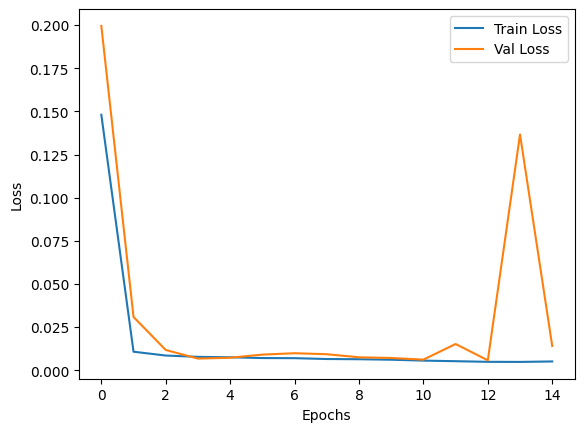

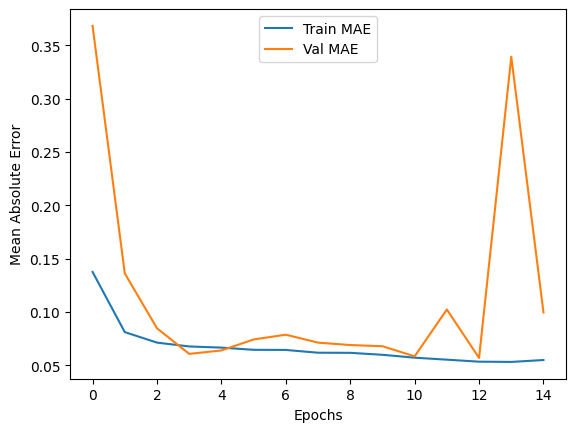

In [ ]:
# Pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━

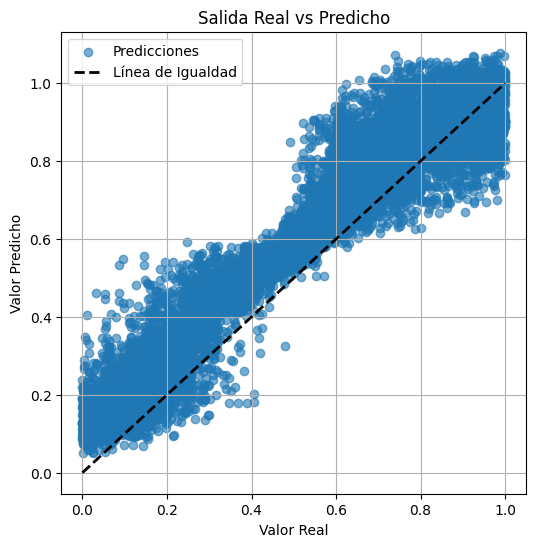

In [ ]:
# Obtener las predicciones del modelo
y_pred_list = []
y_real_list = []

# Iterar sobre val_dataset para extraer datos y hacer predicciones en lotes
for batch_x, batch_y in val_dataset:
    y_pred_batch = model.predict(batch_x)  # Predicción del modelo
    y_pred_list.append(y_pred_batch)
    y_real_list.append(batch_y.numpy())  # Convertir tensores a numpy

# Convertir listas a arrays
y_pred = np.concatenate(y_pred_list, axis=0)
y_real = np.concatenate(y_real_list, axis=0)

# Graficar predicciones vs valores reales
plt.figure(figsize=(6, 6))
plt.scatter(y_real[:, 0], y_pred[:, 0], alpha=0.6, label="Predicciones")
plt.plot([min(y_real[:, 0]), max(y_real[:, 0])],
         [min(y_real[:, 0]), max(y_real[:, 0])], 'k--', lw=2, label="Línea de Igualdad")  # Línea de referencia
plt.title('Salida Real vs Predicho')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
## guardamos los pesos
model.save('/content/drive/MyDrive/DoctoradoPaper1/modelo_resnet_regresionjex2.h5')  # Guarda en formato HDF5

In [ ]:
import torch
torch.cuda.empty_cache()  # Si usas PyTorch

In [ ]:
import gc
import sys

del train_dataset, val_dataset
# Forzar recolección de basura
gc.collect()

150

## T

In [ ]:
# Cargar nuevamente

loaded = np.load("/content/drive/MyDrive/imagenes_comprimidas.npz")
MS = loaded["data"].astype('float16')

In [ ]:
del loaded
# 1. Dividir los datos en entrenamiento, validación y prueba
X_train, X_val, y_train, y_val = train_test_split(MS, T.reshape(-1, 1), test_size=0.2, random_state=42)
del MS
# 2. Aplicar MinMaxScaler a y_train, y_val, y_test
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_val_scaled = scaler.transform(y_val)

# 3. Crear `tf.data.Dataset` y dividir en lotes
batch_size = 64

# Función para convertir numpy arrays en Dataset
def create_tf_dataset(X, y):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(len(X)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Crear datasets en lotes
train_dataset = create_tf_dataset(X_train, y_train_scaled)
val_dataset = create_tf_dataset(X_val, y_val_scaled)

In [ ]:
del X_train, X_val, y_train, y_val,y_train_scaled,y_val_scaled

In [ ]:
# Definir la entrada con la forma correcta (224, 224, 3)
input_layer = Input(shape=(224, 224, 3))

# Cargar el modelo base de DenseNet121 sin la parte superior
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_layer)

# Extraer características con GlobalAveragePooling
x = GlobalAveragePooling2D()(base_model.output)

# Capa densa para regresión (1 salida continua)
output_layer = Dense(1, activation='linear')

# Apply the output layer to the previous tensor 'x' to get the output KerasTensor
outputs = output_layer(x) # This line is changed

# Definir el modelo final
# Use 'outputs' instead of 'output_layer'
model = Model(inputs=input_layer, outputs=outputs) # This line is changed

# Compilar el modelo con una pérdida adecuada para regresión
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Mostrar resumen del modelo
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 23,536,641 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# Definir hiperparámetros
epochs = 15  # Número de épocas
batch_size = 64  # Ya definido en la creación del dataset

# Entrenar el modelo
history = model.fit(
    train_dataset,  # Dataset de entrenamiento
    validation_data=val_dataset,  # Dataset de validación
    epochs=epochs,  # Número de iteraciones sobre los datos
    verbose=1  # Muestra progreso
)


Epoch 1/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 144s 122ms/step - loss: 1.0154 - mae: 0.2715 - val_loss: 0.0904 - val_mae: 0.2236
Epoch 2/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 56s 83ms/step - loss: 0.0209 - mae: 0.1088 - val_loss: 0.0241 - val_mae: 0.1025
Epoch 3/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 56s 83ms/step - loss: 0.0164 - mae: 0.0941 - val_loss: 0.0151 - val_mae: 0.0814
Epoch 4/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 56s 83ms/step - loss: 0.0145 - mae: 0.0878 - val_loss: 0.1047 - val_mae: 0.3042
Epoch 5/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 56s 83ms/step - loss: 0.0159 - mae: 0.0945 - val_loss: 0.0150 - val_mae: 0.0920
Epoch 6/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 56s 83ms/step - loss: 0.0145 - mae: 0.0896 - val_loss: 0.0448 - val_mae: 0.1432
Epoch 7/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 56s 83ms/step - loss: 0.0132 - mae: 0.0865 - val_loss: 0.1046 - val_mae: 0.2543
Epoch 8/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 56s 83ms/step - loss: 0.0134 - mae: 0.0876 - val_loss: 0.0234 - val_mae: 0.1048
Epoch 9/15
676/676 ━━━━━━━━━━━━━━━━━━━

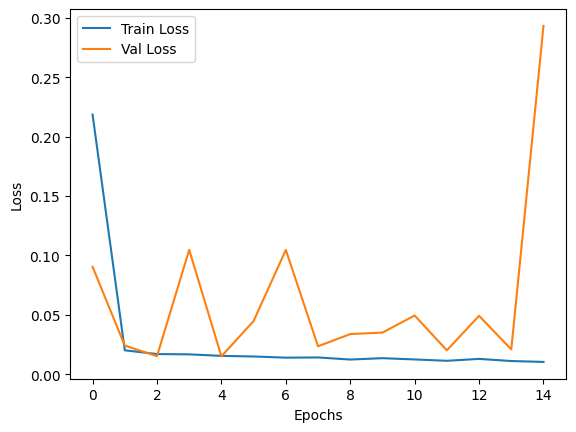

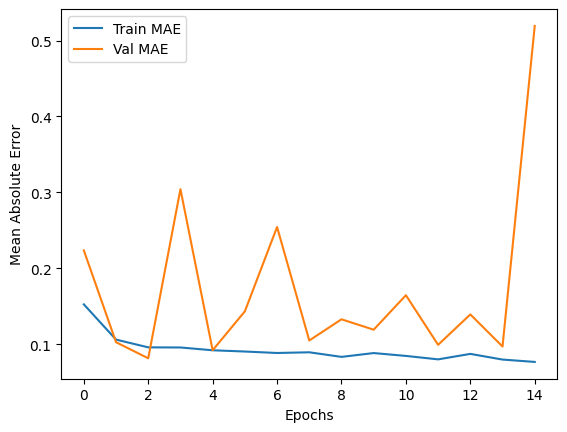

In [ ]:
# Pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━

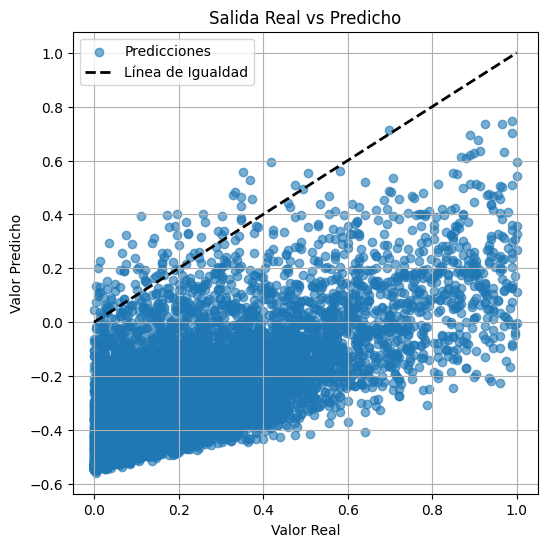

In [ ]:
# Obtener las predicciones del modelo
y_pred_list = []
y_real_list = []

# Iterar sobre val_dataset para extraer datos y hacer predicciones en lotes
for batch_x, batch_y in val_dataset:
    y_pred_batch = model.predict(batch_x)  # Predicción del modelo
    y_pred_list.append(y_pred_batch)
    y_real_list.append(batch_y.numpy())  # Convertir tensores a numpy

# Convertir listas a arrays
y_pred = np.concatenate(y_pred_list, axis=0)
y_real = np.concatenate(y_real_list, axis=0)

# Graficar predicciones vs valores reales
plt.figure(figsize=(6, 6))
plt.scatter(y_real[:, 0], y_pred[:, 0], alpha=0.6, label="Predicciones")
plt.plot([min(y_real[:, 0]), max(y_real[:, 0])],
         [min(y_real[:, 0]), max(y_real[:, 0])], 'k--', lw=2, label="Línea de Igualdad")  # Línea de referencia
plt.title('Salida Real vs Predicho')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
## guardamos los pesos
model.save('/content/drive/MyDrive/DoctoradoPaper1/modelo_ResNet_regresionT.h5')  # Guarda en formato HDF5

## MULTIVARIADO

In [ ]:
# Cargar nuevamente
loaded = np.load("/content/drive/MyDrive/imagenes_comprimidas.npz")
MS = loaded["data"].astype('float16')

In [ ]:
del loaded
# 1. Dividir los datos en entrenamiento, validación y prueba
X_train, X_val, y_train, y_val = train_test_split(MS,np.hstack((np.expand_dims(T, axis=-1),np.expand_dims(Jex2, axis=-1))), test_size=0.2, random_state=42)
del MS
# 2. Aplicar MinMaxScaler a y_train, y_val, y_test
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_val_scaled = scaler.transform(y_val)

# 3. Crear `tf.data.Dataset` y dividir en lotes
batch_size = 64

# Función para convertir numpy arrays en Dataset
def create_tf_dataset(X, y):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(len(X)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Crear datasets en lotes
train_dataset = create_tf_dataset(X_train, y_train_scaled)
val_dataset = create_tf_dataset(X_val, y_val_scaled)

In [ ]:
del X_train, X_val, y_train, y_val,y_train_scaled,y_val_scaled

In [ ]:
# Definir la entrada con la forma correcta (224, 224, 3)
input_layer = Input(shape=(224, 224, 3))

# Cargar el modelo base de DenseNet121 sin la parte superior
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_layer)

# Extraer características con GlobalAveragePooling
x = GlobalAveragePooling2D()(base_model.output)

# Capa densa para regresión (1 salida continua)
output_layer = Dense(2, activation='linear')

# Apply the output layer to the previous tensor 'x' to get the output KerasTensor
outputs = output_layer(x) # This line is changed

# Definir el modelo final
# Use 'outputs' instead of 'output_layer'
model = Model(inputs=input_layer, outputs=outputs) # This line is changed

# Compilar el modelo con una pérdida adecuada para regresión
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Mostrar resumen del modelo
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 23,538,690 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# Definir hiperparámetros
epochs = 15  # Número de épocas
batch_size = 64  # Ya definido en la creación del dataset

# Entrenar el modelo
history = model.fit(
    train_dataset,  # Dataset de entrenamiento
    validation_data=val_dataset,  # Dataset de validación
    epochs=epochs,  # Número de iteraciones sobre los datos
    verbose=1  # Muestra progreso
)


Epoch 1/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 152s 129ms/step - loss: 0.2731 - mae: 0.2158 - val_loss: 0.1115 - val_mae: 0.2593
Epoch 2/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 57s 85ms/step - loss: 0.0116 - mae: 0.0782 - val_loss: 0.0198 - val_mae: 0.1160
Epoch 3/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 57s 84ms/step - loss: 0.0108 - mae: 0.0750 - val_loss: 0.0101 - val_mae: 0.0700
Epoch 4/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 57s 84ms/step - loss: 0.0100 - mae: 0.0723 - val_loss: 0.1075 - val_mae: 0.1985
Epoch 5/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 57s 84ms/step - loss: 0.0097 - mae: 0.0712 - val_loss: 0.0184 - val_mae: 0.1050
Epoch 6/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 57s 85ms/step - loss: 0.0088 - mae: 0.0677 - val_loss: 0.0116 - val_mae: 0.0756
Epoch 7/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 57s 84ms/step - loss: 0.0086 - mae: 0.0681 - val_loss: 0.0137 - val_mae: 0.0835
Epoch 8/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 57s 85ms/step - loss: 0.0084 - mae: 0.0672 - val_loss: 0.0128 - val_mae: 0.0789
Epoch 9/15
676/676 ━━━━━━━━━━━━━━━━━━━

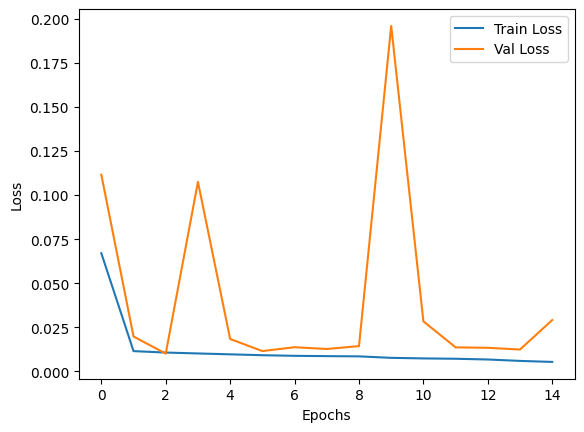

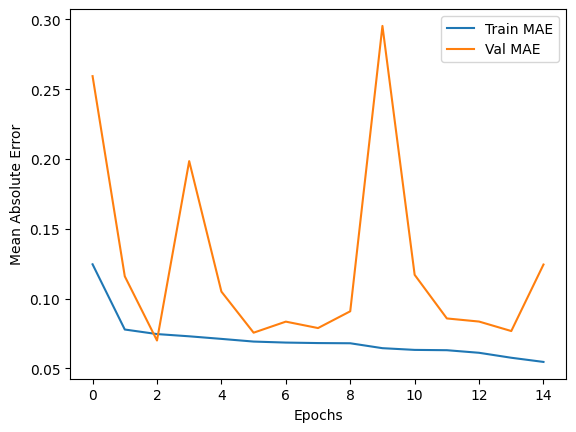

In [ ]:
# Pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━

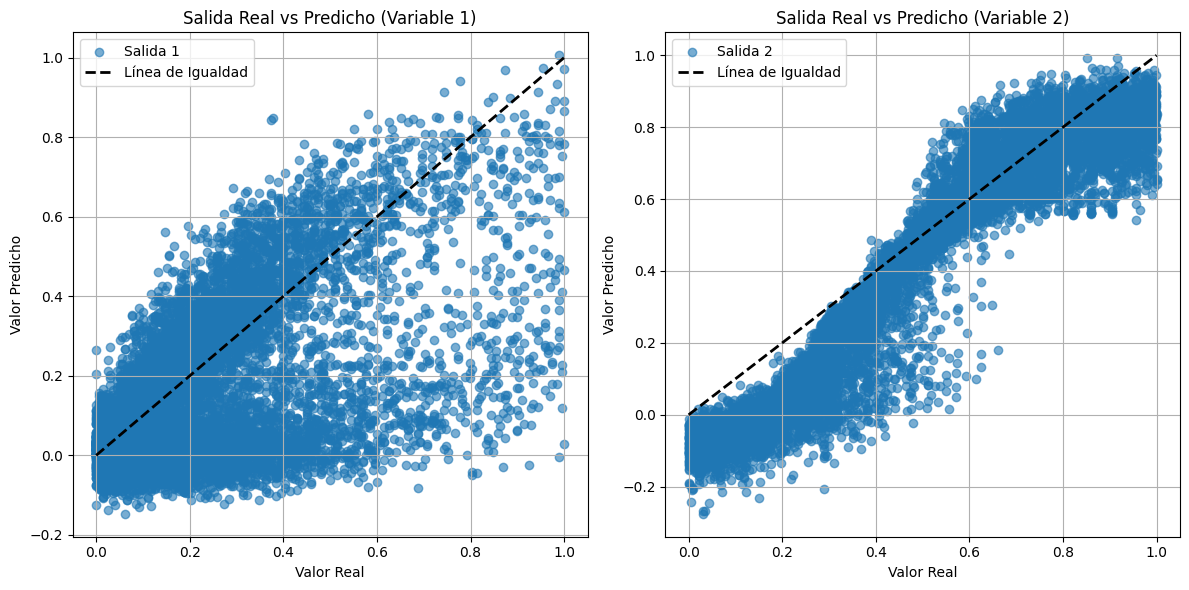

In [ ]:

# Obtener las predicciones del modelo
y_pred_list = []
y_real_list = []

# Iterar sobre val_dataset para extraer datos y hacer predicciones en lotes
for batch_x, batch_y in val_dataset:
    y_pred_batch = model.predict(batch_x)  # Predicción del modelo (ahora con 2 salidas)
    y_pred_list.append(y_pred_batch)
    y_real_list.append(batch_y.numpy())  # Convertir tensores a numpy

# Convertir listas a arrays
y_pred = np.concatenate(y_pred_list, axis=0)  # (N, 2)
y_real = np.concatenate(y_real_list, axis=0)  # (N, 2)

# Graficar cada salida por separado
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 2 gráficos lado a lado

for i in range(2):  # Para ambas salidas
    axes[i].scatter(y_real[:, i], y_pred[:, i], alpha=0.6, label=f'Salida {i+1}')
    axes[i].plot([min(y_real[:, i]), max(y_real[:, i])],
                 [min(y_real[:, i]), max(y_real[:, i])], 'k--', lw=2, label="Línea de Igualdad")
    axes[i].set_title(f'Salida Real vs Predicho (Variable {i+1})')
    axes[i].set_xlabel('Valor Real')
    axes[i].set_ylabel('Valor Predicho')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
## guardamos los pesos
model.save('/content/drive/MyDrive/DoctoradoPaper1/modelo_ResNet_regresionTJex2.h5')  # Guarda en formato HDF5